In [108]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import gzip
import json
from matplotlib import pyplot as plt

def load_jsonlines_to_df(file_path):
    """
    Loads a gzipped JSON Lines file into a Pandas DataFrame,
    processes the 'accession_type' to ensure it's a single string label,
    balances the dataset by sampling up to 10000 instances per class,
    and selects only the specified columns.

    :param file_path: Path to the .jsonl.gz file.
    :return: A balanced Pandas DataFrame with selected columns and a LabelEncoder.
    """
    with gzip.open(file_path, 'rt', encoding='utf-8') as gzfile:
        data = [json.loads(line) for line in gzfile]
    
    columns_to_keep = ['abstract', 'accession_type']
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df = df[columns_to_keep]
    
    # Ensure 'accession_type' exists
    if 'accession_type' not in df.columns:
        raise KeyError("Column 'accession_type' not found in the dataset.")
    
    # Process 'accession_type' to ensure it's a single string
    df['accession_type'] = df['accession_type'].apply(
        lambda labels: 'metagenomics' if 'metagenomics' in labels else 'other'
    )
    
    # Encode 'accession_type' into 'label'
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['accession_type'])
    
    # Balance the dataset: sample up to 10000 instances per class
    # df_balanced = df.groupby('accession_type').apply(
    #     lambda x: x.sample(n=min(9500, len(x)), random_state=0)
    # ).reset_index(drop=True)

    df_balanced = df.copy()
    # Diagnostic Checks
    print(f"Loaded DataFrame shape: {df_balanced.shape}")
    print("Label distribution after balancing:")
    print(df_balanced['accession_type'].value_counts())
    print("\nSample data:")
    print(df_balanced.head())
    
    df_balanced.rename(columns={'accession_type': 'class_label'}, inplace=True)
    return df_balanced, label_encoder

# File paths
file_path = '/home/stirunag/work/github/article_classifier/data/final_multi_label_trainingset.jsonl.gz'

data, label_encoder = load_jsonlines_to_df(file_path)
# Sample size
# n = 10000  # Set your desired sample size
# 
data
# 
# data

Loaded DataFrame shape: (219802, 3)
Label distribution after balancing:
accession_type
other           210302
metagenomics      9500
Name: count, dtype: int64

Sample data:
                                            abstract accession_type  label
0  Down-regulation of the Drosophila ribosomal pr...          other      1
1  Human chromosomal region 1q24 encodes two clon...          other      1
2  A bovine plasminogen activator was purified fr...          other      1
3  Staphylococcus aureus and Staphylococcus epide...          other      1
4  Kinetic analysis of two mutations within Pseud...          other      1


,abstract,class_label,label
0,Down-regulation of the Drosophila ribosomal pr...,other,1
1,Human chromosomal region 1q24 encodes two clon...,other,1
2,A bovine plasminogen activator was purified fr...,other,1
3,Staphylococcus aureus and Staphylococcus epide...,other,1
4,Kinetic analysis of two mutations within Pseud...,other,1
...,...,...,...
219797,Kaposi's sarcoma-associated herpesvirus (KSHV)...,other,1
219798,The pathway of autotrophic CO2 fixation was st...,other,1
219799,The mannose-sensitive hemagglutinin (MSHA) of ...,other,1
219800,Pseudomonas putida GJ31 contains an unusual ca...,other,1


In [109]:
# Check class distribution
data['abstract_length'] = data['abstract'].apply(len)
print(data['class_label'].value_counts())


class_label
other           210302
metagenomics      9500
Name: count, dtype: int64


In [110]:
# Abstract length statistics by class
class_stats = data.groupby('class_label')['abstract_length'].describe()
print(class_stats)

                 count         mean         std   min     25%     50%     75%  \
class_label                                                                     
metagenomics    9500.0  1516.029368  518.698459  39.0  1179.0  1508.0  1798.0   
other         210302.0  1551.310644  523.698460   4.0  1200.0  1511.0  1831.0   

                  max  
class_label            
metagenomics  10114.0  
other         32065.0  


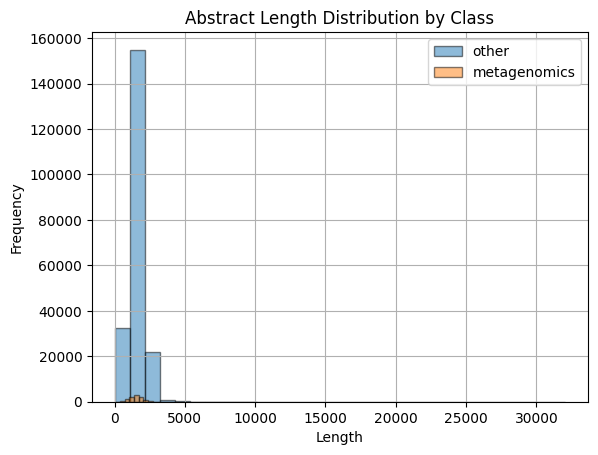

In [111]:
# Visualize distribution by class
classes = data['class_label'].unique()

for cls in classes:
    subset = data[data['class_label'] == cls]
    subset['abstract_length'].hist(bins=30, alpha=0.5, label=cls, edgecolor='k')

plt.title('Abstract Length Distribution by Class')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


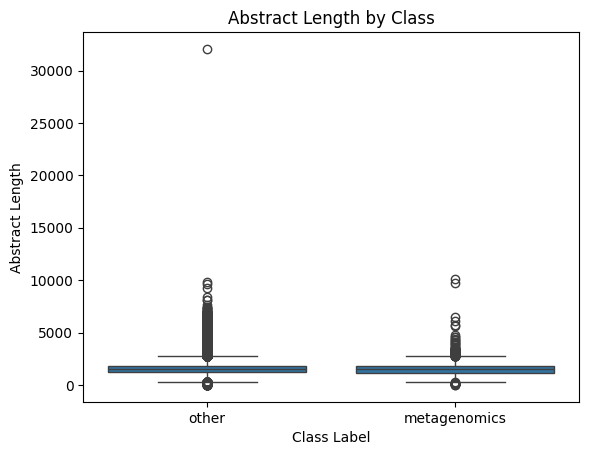

In [112]:
# Boxplot of abstract lengths by class
import seaborn as sns

sns.boxplot(x='class_label', y='abstract_length', data=data)
plt.title('Abstract Length by Class')
plt.xlabel('Class Label')
plt.ylabel('Abstract Length')
plt.show()


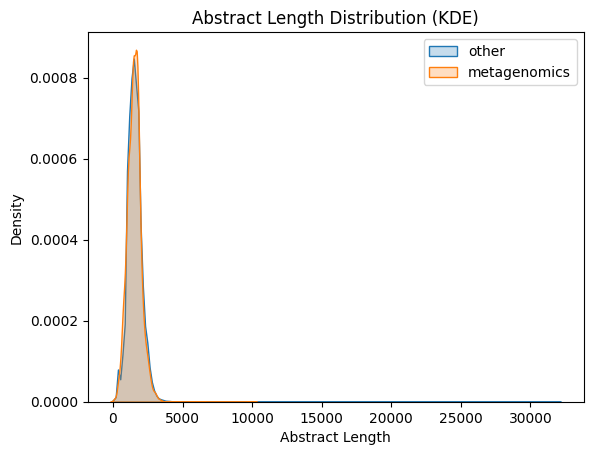

In [113]:
# KDE plot for both classes
for cls in classes:
    subset = data[data['class_label'] == cls]
    sns.kdeplot(subset['abstract_length'], label=cls, fill=True)

plt.title('Abstract Length Distribution (KDE)')
plt.xlabel('Abstract Length')
plt.ylabel('Density')
plt.legend()
plt.show()


In [114]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['length_normalized'] = scaler.fit_transform(data[['abstract_length']])

# Check a few rows
print(data[['abstract_length', 'length_normalized']].head())
data

   abstract_length  length_normalized
0             1055           0.032781
1             1016           0.031565
2             1336           0.041546
3             1845           0.057422
4              482           0.014909


,abstract,class_label,label,abstract_length,length_normalized
0,Down-regulation of the Drosophila ribosomal pr...,other,1,1055,0.032781
1,Human chromosomal region 1q24 encodes two clon...,other,1,1016,0.031565
2,A bovine plasminogen activator was purified fr...,other,1,1336,0.041546
3,Staphylococcus aureus and Staphylococcus epide...,other,1,1845,0.057422
4,Kinetic analysis of two mutations within Pseud...,other,1,482,0.014909
...,...,...,...,...,...
219797,Kaposi's sarcoma-associated herpesvirus (KSHV)...,other,1,1593,0.049562
219798,The pathway of autotrophic CO2 fixation was st...,other,1,2240,0.069742
219799,The mannose-sensitive hemagglutinin (MSHA) of ...,other,1,1339,0.041639
219800,Pseudomonas putida GJ31 contains an unusual ca...,other,1,1391,0.043261


In [115]:
data['word_count'] = data['abstract'].apply(lambda x: len(x.split()))
print(data[['abstract', 'word_count']].head())


                                            abstract  word_count
0  Down-regulation of the Drosophila ribosomal pr...         149
1  Human chromosomal region 1q24 encodes two clon...         160
2  A bovine plasminogen activator was purified fr...         203
3  Staphylococcus aureus and Staphylococcus epide...         254
4  Kinetic analysis of two mutations within Pseud...          68


In [116]:
data['lexical_diversity'] = data['abstract'].apply(lambda x: len(set(x.split())) / len(x.split()))
print(data[['abstract', 'lexical_diversity']].head())


                                            abstract  lexical_diversity
0  Down-regulation of the Drosophila ribosomal pr...           0.704698
1  Human chromosomal region 1q24 encodes two clon...           0.706250
2  A bovine plasminogen activator was purified fr...           0.591133
3  Staphylococcus aureus and Staphylococcus epide...           0.602362
4  Kinetic analysis of two mutations within Pseud...           0.779412


In [117]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['cleaned_abstract'] = data['abstract'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stirunag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
# Include n-grams (1, 2, and 3 grams)
tfidf = TfidfVectorizer(
    max_features=5000,  # Increase the feature count if needed
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    stop_words='english',  # Exclude common stop words
    sublinear_tf=True,  # Apply sublinear term frequency scaling
)

# Transform the cleaned abstracts
tfidf_matrix = tfidf.fit_transform(data['cleaned_abstract'])

# Print shape of the matrix
print("TF-IDF Shape:", tfidf_matrix.shape)

TF-IDF Shape: (219802, 5000)


In [119]:
# Extract structural features
data['num_sentences'] = data['abstract'].apply(lambda x: x.count('.'))
data['num_numbers'] = data['abstract'].apply(lambda x: len(re.findall(r'\d+', x)))
data['has_sections'] = data['abstract'].apply(lambda x: int(any(keyword in x.lower() for keyword in ['background', 'methods', 'results', 'conclusion'])))

print(data[['num_sentences', 'num_numbers', 'has_sections']].head())


   num_sentences  num_numbers  has_sections
0              5           10             0
1              7            8             0
2             13            8             0
3             14            6             0
4              2            4             0


In [123]:
import spacy
import os
from dotenv import load_dotenv
import numpy as np
from tqdm import tqdm
# Load .env_paths using the relative path from python_scripts
# load_dotenv('../../.env_paths')
load_dotenv('/home/stirunag/work/github/CAPITAL/daily_pipeline/.env_paths')

# Load paths from .env_paths
spacy_model_path = os.getenv("SPACY_MODEL_PATH")

# Verify paths are loaded correctly
if not spacy_model_path:
    raise ValueError("SPACY_MODEL_PATH must be set in .env_paths")

# Load spaCy model
print("Loading spaCy model for entity linking...")
spacy_model = spacy.load(spacy_model_path)
print("SpaCy model loaded successfully.")

def process_in_batches(terms, model, mean_vector, batch_size=500):
    embeddings = []
    for i in tqdm(range(0, len(terms), batch_size), desc="Processing in Batches"):
        batch = terms[i:i + batch_size]
        embeddings.extend(get_average_embeddings_batched(batch, model, mean_vector))
    return embeddings



# Calculate mean vector from spaCy model's vocabulary
def calculate_mean_vector(model):
    vectors = np.array([word.vector for word in model.vocab if word.has_vector and word.vector.shape[0] == 300])
    if len(vectors) > 0:
        mean_vector = np.mean(vectors, axis=0)
        return mean_vector
    else:
        return np.zeros((300,))

# Get average embeddings for terms using spaCy model
def get_average_embeddings_batched(terms, model, mean_vector):
    # Disable unnecessary components for speed
    docs = list(model.pipe(terms, disable=["parser", "ner"]))
    embeddings = []
    for doc in docs:
        valid_vectors = [token.vector for token in doc if token.has_vector and token.vector.shape[0] == 300]
        if len(valid_vectors) == 0:
            embeddings.append(mean_vector)
        else:
            average_embedding = np.mean(valid_vectors, axis=0)
            embeddings.append(average_embedding)
    return embeddings


# Compute cosine similarity between each abstract and class-specific means
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

Loading spaCy model for entity linking...


/home/stirunag/falconframes_env/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.2.5 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


SpaCy model loaded successfully.


In [125]:
mean_vector = calculate_mean_vector(spacy_model)  # Fallback mean vector
# Get embeddings for all abstracts (calculate once)
all_abstracts = data['cleaned_abstract'].tolist()
all_embeddings = process_in_batches(all_abstracts, spacy_model, mean_vector)

 # Save embeddings to a file (e.g., pickle or NumPy)
import pickle

with open('all_embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)


Processing in Batches: 100%|██████████| 440/440 [31:36<00:00,  4.31s/it]


In [126]:
# Save embeddings as a column in the DataFrame for reuse
data['embedding'] = all_embeddings
# Filter embeddings by class
metagenomics_embeddings = np.array(data[data['class_label'] == 'metagenomics']['embedding'].tolist())
other_embeddings = np.array(data[data['class_label'] == 'other']['embedding'].tolist())

# Compute mean embeddings for each class
metagenomics_mean = np.mean(metagenomics_embeddings, axis=0)
other_mean = np.mean(other_embeddings, axis=0)

# Compute similarity scores for all abstracts
data['similarity_metagenomics_mean'] = data['embedding'].apply(lambda x: cosine_similarity(x, metagenomics_mean))
data['similarity_other_mean'] = data['embedding'].apply(lambda x: cosine_similarity(x, other_mean))

# Check the updated DataFrame
print(data[['similarity_metagenomics_mean', 'similarity_other_mean']].head())



   similarity_metagenomics_mean  similarity_other_mean
0                      0.840082               0.916328
1                      0.814875               0.887066
2                      0.784179               0.879520
3                      0.788677               0.870380
4                      0.678002               0.775018


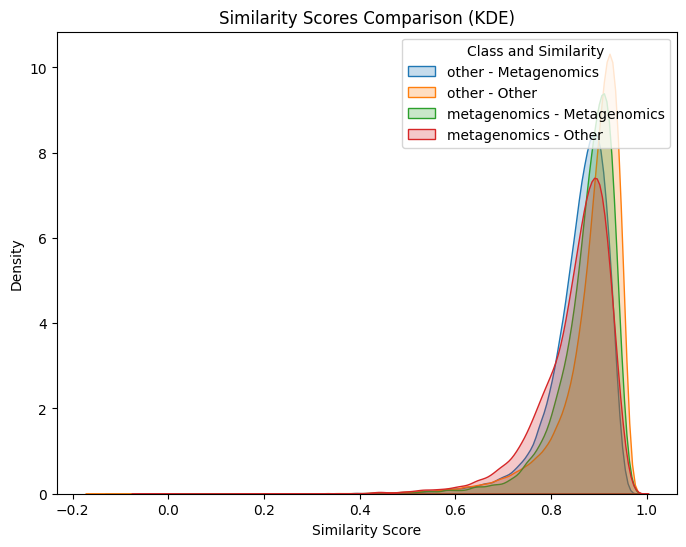

In [128]:
# Combined KDE plot for both similarity scores
plt.figure(figsize=(8, 6))
for cls in data['class_label'].unique():
    subset = data[data['class_label'] == cls]
    sns.kdeplot(subset['similarity_metagenomics_mean'], label=f'{cls} - Metagenomics', fill=True)
    sns.kdeplot(subset['similarity_other_mean'], label=f'{cls} - Other', fill=True)

plt.title('Similarity Scores Comparison (KDE)')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend(title='Class and Similarity')
plt.show()


In [188]:
from scipy.sparse import hstack

# Combine features
similarity_features = data[['similarity_metagenomics_mean', 'similarity_other_mean']].values
X_numerical = data[['abstract_length', 'word_count', 'lexical_diversity','num_sentences', 'num_numbers', 'has_sections']].values
X_combined = hstack([tfidf_matrix]) # , similarity_features, X_numerical

# Target variable
y = data['class_label']


In [189]:
from sklearn.model_selection import train_test_split
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.3, random_state=42)

print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


Training Set Size: (153861, 5000)
Testing Set Size: (65941, 5000)


In [190]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
# Split data


# Train Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)




# Train Logistic Regression
logistic_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logistic_clf.fit(X_train, y_train)

# Train LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': len(set(y_encoded)),
    'metric': 'multi_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lightgbm_clf = lgb.train(params, train_data, num_boost_round=100)


In [191]:
# Get predictions from Logistic Regression
logistic_preds = logistic_clf.predict_proba(X_test)

# Get predictions from LightGBM
lightgbm_preds = lightgbm_clf.predict(X_test)

# Get predictions and probabilities from Naive Bayes
nb_preds = nb_clf.predict_proba(X_test)


In [193]:
# Combine predictions into a new dataset
stacked_features_train = np.hstack([
    logistic_clf.predict_proba(X_train),
    lightgbm_clf.predict(X_train),
    nb_clf.predict_proba(X_train)
])
stacked_features_test = np.hstack([
    logistic_preds,
    lightgbm_preds,
    nb_preds
])

# Train a meta-classifier
meta_clf = LogisticRegression(max_iter=1000, random_state=42)
meta_clf.fit(stacked_features_train, y_train)

# Evaluate the meta-classifier
meta_preds = meta_clf.predict(stacked_features_test)
print(classification_report(y_test, meta_preds))


              precision    recall  f1-score   support

           0       0.57      0.30      0.39      2905
           1       0.97      0.99      0.98     63036

    accuracy                           0.96     65941
   macro avg       0.77      0.64      0.69     65941
weighted avg       0.95      0.96      0.95     65941



In [194]:
# Average probabilities from all three models
weights = [0.5, 0.5, 0.0]  # Adjust weights as needed
final_probs = (weights[0] * logistic_preds + weights[1] * lightgbm_preds + weights[2] * nb_preds)

# Choose the class with the highest probability
final_preds = np.argmax(final_probs, axis=1)

# Evaluate the ensemble
print(classification_report(y_test, final_preds))


              precision    recall  f1-score   support

           0       0.41      0.53      0.46      2905
           1       0.98      0.97      0.97     63036

    accuracy                           0.95     65941
   macro avg       0.70      0.75      0.72     65941
weighted avg       0.95      0.95      0.95     65941



In [195]:
# Adjust threshold for minority class
threshold = 0.8  # Example threshold
final_preds = (final_probs[:, 1] > threshold).astype(int)
print(classification_report(y_test, final_preds))


              precision    recall  f1-score   support

           0       0.16      0.85      0.27      2905
           1       0.99      0.80      0.88     63036

    accuracy                           0.80     65941
   macro avg       0.58      0.83      0.58     65941
weighted avg       0.96      0.80      0.86     65941



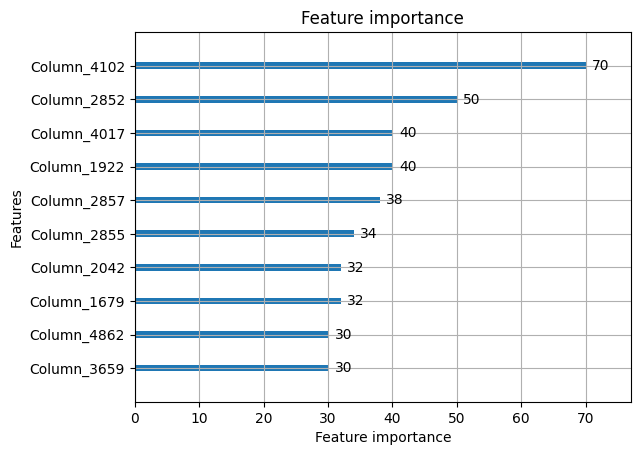

In [196]:
lgb.plot_importance(lightgbm_clf, max_num_features=10)
plt.show()
